In [10]:
import os
from dotenv import load_dotenv
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt

from preprocessing.cleaner import TextCleaner, IndonesianNewsCleaner, FinanceCleaner, CleanerPipeline
from preprocessing.deduplicater import dedup_splits, overlap_counts

from sklearn.model_selection import train_test_split

from preprocessing.dataset import xy_from_df

from news_classification.utils.labels import coerce_labels
from news_classification.models.model import HierarchicalSVMModel
from news_classification.bundler import save_bundle, load_bundle

from pathlib import Path

load_dotenv()

True

In [2]:
HF_DATASET = os.getenv("HF_DATASET")
HF_TOKEN = os.getenv("HF_TOKEN")

ds = load_dataset(HF_DATASET, token=HF_TOKEN)
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 11893
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 4117
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 5097
    })
})

In [3]:
train_df = ds["train"].to_pandas()
val_df = ds["validation"].to_pandas()
test_df = ds["test"].to_pandas()

In [4]:
train_df

,label,text
0,16,Anggota parlemen Demokrat mengatakan menindak...
1,9,F1 selalu kesulitan menemukan basis penggemar...
2,15,"RATA-RATA SAHAM NIKKEI TOKYO DIBUKA 1,42% PAD..."
3,18,$LVS - Las Vegas Sands Memiliki Masalah Penda...
4,14,Pertumbuhan ekonomi China kemungkinan akan te...
...,...,...
11888,2,"Morgan Olson, EAVX memperkenalkan bodi van la..."
11889,9,Dari Breakingviews - Krisis properti China me...
11890,2,Energy Vault Mengumumkan Perpanjangan Sukarela...
11891,18,$TNEYF - Tamarack Valley Energy: Pejuang Zama...


In [11]:
label_col = "label"

counts = pd.concat(
    {
        "train": train_df[label_col].value_counts(dropna=False),
        "val":   val_df[label_col].value_counts(dropna=False),
        "test":  test_df[label_col].value_counts(dropna=False),
    },
    axis=1
).fillna(0).astype(int)

counts["total"] = counts.sum(axis=1)

counts = counts.sort_values("total", ascending=False)

counts

,train,val,test,total
label,,,,
2,2474,852,1071,4397
18,1493,528,625,2646
14,1279,415,543,2237
9,1109,336,448,1893
16,650,249,335,1234
5,695,242,292,1229
1,590,214,247,1051
19,575,197,248,1020
7,435,160,189,784


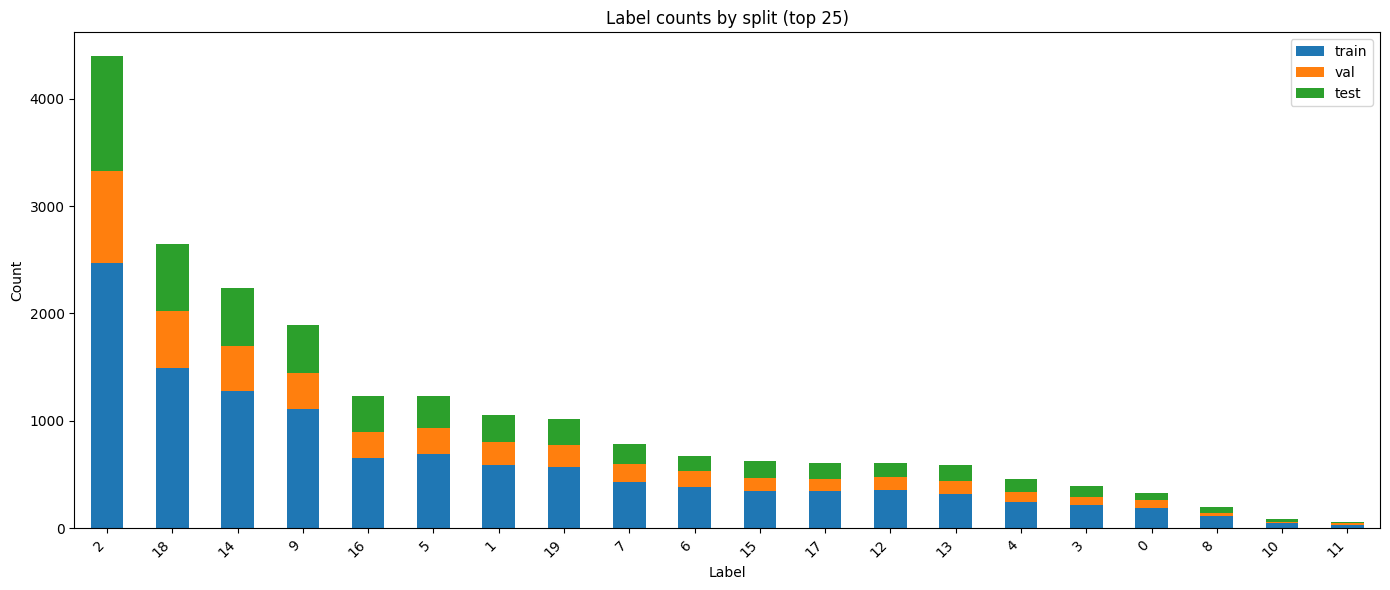

In [12]:
plot_cols = ["train", "val", "test"]

top_n = 25
plot_df = counts.sort_values("total", ascending=False).head(top_n)[plot_cols]

ax = plot_df.plot(kind="bar", stacked=True, figsize=(14, 6))
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title(f"Label counts by split (top {top_n})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
label_col = "label"

counts = pd.concat(
    {
        "train": train_df[label_col].value_counts(dropna=False),
        "val":   val_df[label_col].value_counts(dropna=False),
        "test":  test_df[label_col].value_counts(dropna=False),
    },
    axis=1
).fillna(0).astype(int)

counts["total"] = counts.sum(axis=1)

counts = counts.sort_values("total", ascending=False)

counts

,train,val,test,total
label,,,,
2,2474,852,1071,4397
18,1493,528,625,2646
14,1279,415,543,2237
9,1109,336,448,1893
16,650,249,335,1234
5,695,242,292,1229
1,590,214,247,1051
19,575,197,248,1020
7,435,160,189,784


In [5]:
print(overlap_counts(train_df, val_df, test_df, text_col="text", key_fn=TextCleaner.normalize))

{'train_val': 453, 'train_test': 560, 'val_test': 219, 'train': 11001, 'val': 3970, 'test': 4883}


In [6]:
train_df2, val_df2, test_df2, rep = dedup_splits(
    train_df, val_df, test_df,
    text_col="text",
    key_fn=TextCleaner.normalize,
    dedup_within=True,
)

print(overlap_counts(train_df2, val_df2, test_df2, text_col="text", key_fn=TextCleaner.normalize))

{'train_val': 0, 'train_test': 0, 'val_test': 0, 'train': 11001, 'val': 3517, 'test': 4193}


In [7]:
X_train, y_train = xy_from_df(train_df2, "text", "label")
X_val, y_val = xy_from_df(val_df2, "text", "label")
X_test, y_test = xy_from_df(test_df2, "text", "label")

In [8]:
clean_fn = CleanerPipeline((IndonesianNewsCleaner, FinanceCleaner))
model = HierarchicalSVMModel(clean_fn=clean_fn)

In [9]:
model.fit(X_train, y_train, X_val_text=X_val, y_val=y_val, tune=True, refit_on_train_val=True)

val_metrics = model.evaluate(X_val, y_val)
test_metrics = model.evaluate(X_test, y_test)

print("VAL macro_f1:", val_metrics["macro_f1"])
print("TEST macro_f1:", test_metrics["macro_f1"])

[I 2026-01-01 22:35:50,567] A new study created in memory with name: no-name-55afceaa-7ea9-4cc0-9506-15ce59f663f1
[I 2026-01-01 22:35:53,975] Trial 0 finished with value: 0.7885041440135432 and parameters: {'ngram_max': 2, 'min_df': 4, 'max_df': 0.9145789510140103, 'word_max_features': 135000, 'char_max_features': 140000, 'C': 2.217906478283943}. Best is trial 0 with value: 0.7885041440135432.
[I 2026-01-01 22:35:57,333] Trial 1 finished with value: 0.7672121082340875 and parameters: {'ngram_max': 1, 'min_df': 4, 'max_df': 0.9040717841449928, 'word_max_features': 80000, 'char_max_features': 60000, 'C': 3.2069049195101313}. Best is trial 0 with value: 0.7885041440135432.
[I 2026-01-01 22:35:59,755] Trial 2 finished with value: 0.787255306852519 and parameters: {'ngram_max': 1, 'min_df': 4, 'max_df': 0.8788692470541464, 'word_max_features': 135000, 'char_max_features': 220000, 'C': 0.2376093967746241}. Best is trial 0 with value: 0.7885041440135432.
[I 2026-01-01 22:36:02,292] Trial 3 fi

VAL macro_f1: 0.9991087419473604
TEST macro_f1: 0.8058238829216687


In [10]:
res = model.evaluate(X_test, y_test)

display(res["report_df"])
display(res["confusion_df"])
display(res["top_confusions_df"])
print(res["report_text"])

,precision,recall,f1-score,support
0,0.740741,0.634921,0.683761,63.000000
1,0.807229,0.797619,0.802395,168.000000
10,0.750000,0.750000,0.750000,16.000000
11,0.900000,0.900000,0.900000,10.000000
12,0.797980,0.774510,0.786070,102.000000
13,0.830645,0.735714,0.780303,140.000000
14,0.749280,0.771513,0.760234,337.000000
15,0.795276,0.731884,0.762264,138.000000
16,0.913386,0.892308,0.902724,260.000000
17,0.937008,0.850000,0.891386,140.000000


,0,1,10,11,12,13,14,15,16,17,18,19,2,3,4,5,6,7,8,9
0,40,0,0,0,1,1,2,2,0,0,5,5,4,0,0,0,1,0,0,2
1,0,134,0,0,1,0,16,2,4,0,1,1,2,3,0,0,2,0,1,1
10,0,0,12,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0
11,0,0,0,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
12,0,1,0,0,79,2,2,0,0,0,1,0,8,0,0,0,1,0,0,8
13,0,1,0,1,2,103,0,0,0,0,5,2,22,1,0,0,1,0,0,2
14,1,9,0,0,0,0,260,3,1,0,6,1,20,1,0,0,13,0,0,22
15,0,3,0,0,0,0,9,101,0,0,12,3,3,3,0,0,1,0,2,1
16,0,1,0,0,2,0,4,0,232,1,0,0,7,1,0,0,1,0,0,11
17,0,1,0,0,0,0,1,0,2,119,3,0,12,0,0,0,0,0,0,2


,true,pred,count
0,2,18,34
1,9,2,30
2,2,9,29
3,9,14,22
4,13,2,22
5,14,9,22
6,14,2,20
7,1,14,16
8,3,2,14
9,18,2,13


              precision    recall  f1-score   support

           0       0.74      0.63      0.68        63
           1       0.81      0.80      0.80       168
          10       0.75      0.75      0.75        16
          11       0.90      0.90      0.90        10
          12       0.80      0.77      0.79       102
          13       0.83      0.74      0.78       140
          14       0.75      0.77      0.76       337
          15       0.80      0.73      0.76       138
          16       0.91      0.89      0.90       260
          17       0.94      0.85      0.89       140
          18       0.83      0.90      0.87       582
          19       0.83      0.82      0.83       240
           2       0.84      0.86      0.85       938
           3       0.72      0.59      0.65        71
           4       0.93      0.97      0.95       115
           5       0.94      0.93      0.94       285
           6       0.73      0.80      0.76        99
           7       0.92    

In [11]:
out_dir = Path("artifacts/indo_finance_v1")

state = model.get_state()

cleaner_meta = {
    "cleaning": {
        "pipeline": ["IndonesianNewsCleaner", "FinanceCleaner"],
        "module": "news_classification.preprocessing.cleaner",
    }
}

save_bundle(
    out_dir,
    preprocessor=model.preprocessor_,
    clf=model.clf_,
    le=model.le_,
    le_aggregate=model.le_aggregate_,
    aggregate_map=model.aggregate_map_,
    best_params=model.best_params,
    val_macro_f1=model.val_macro_f1,
    test_macro_f1=test_metrics["macro_f1"],
    dataset="intanm/indonesian-financial-topic-classification-dataset",
    text_columns=("text",),
    label_column="label",
    extra_meta=cleaner_meta,
)

(WindowsPath('artifacts/indo_finance_v1/bundle.joblib'),
 WindowsPath('artifacts/indo_finance_v1/meta.json'))

In [12]:
payload = load_bundle(out_dir)

clean_fn = CleanerPipeline((IndonesianNewsCleaner, FinanceCleaner))
model2 = HierarchicalSVMModel(clean_fn=clean_fn).from_state(payload)

In [13]:
model2.predict(["Ini adalah berita tentang keuangan dan investasi di Indonesia."])

array(['9'], dtype=object)